<h1 align="center">Logistic Regression to Assess Customer Churn</h1> 
<center>
Kelseyann Wright </br>

<h2>Data Cleaning & Data Transformation</h2>

In [62]:
#import all necessary libraries and set up workspace
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


pd.set_option('display.max_columns', None)

In [131]:
#load data, check for nulls and duplicates
dat = pd.read_csv("~/Desktop/WGU/D208/churn_clean.csv") #load data CSV
print("number of duplicates:", dat.duplicated().sum()) #count and print number of duplicates
print("number of nulls:", dat.isna().sum().sum())

#remove object columns with high cardinality (more than 5 groups)
uniqueVal = dat.select_dtypes(include='object').nunique()
cardcols = uniqueVal[uniqueVal>5].index
datmod=dat
datmod.drop(list(cardcols), inplace=True, axis=1) 
datmod.drop(['CaseOrder', 'Zip', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'], inplace=True, axis=1)

number of duplicates: 0
number of nulls: 0


In [132]:
#replace yes/no with 1/0
obj_cols = datmod.select_dtypes(include=['object']).columns
for i in obj_cols:
    datmod = datmod.replace({i: {'Yes': 1, 'No': 0}}) #replace yes / no cols with 1 / 0

#create dummy variables for other object columns
obj_cols = datmod.select_dtypes(include=['object']).columns #define remaining object columns
datmod = pd.get_dummies(datmod, columns=obj_cols) #create dummy variables
datmod.head()

,Lat,Lng,Population,Children,Age,Income,Churn,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Techie,Port_modem,Tablet,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Tenure,MonthlyCharge,Bandwidth_GB_Year,Area_Rural,Area_Suburban,Area_Urban,Marital_Divorced,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Gender_Female,Gender_Male,Gender_Nonbinary,Contract_Month-to-month,Contract_One year,Contract_Two Year,InternetService_DSL,InternetService_Fiber Optic,InternetService_None,PaymentMethod_Bank Transfer(automatic),PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check
0,56.25100,-133.37571,38,0,68,28561.99,0,7.978323,10,0,1,0,1,1,1,0,1,1,0,0,0,1,1,6.795513,172.455519,904.536110,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0
1,44.32893,-84.24080,10446,1,27,21704.77,1,11.699080,12,0,1,1,0,1,1,1,1,0,0,0,1,1,1,1.156681,242.632554,800.982766,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
2,45.35589,-123.24657,3735,4,50,9609.57,0,10.752800,9,0,1,1,1,0,1,1,0,0,0,0,0,1,1,15.754144,159.947583,2054.706961,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0
3,32.96687,-117.24798,13863,1,48,18925.23,0,14.913540,15,2,0,1,0,0,1,0,1,0,0,0,1,0,1,17.087227,119.956840,2164.579412,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1
4,29.38012,-95.80673,11352,0,83,40074.19,1,8.147417,16,2,1,0,1,0,0,0,0,0,0,1,1,0,0,1.670972,149.948316,271.493436,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1


In [133]:
datmod['Churn'] = datmod['Churn'].astype('category')
datmod.iloc[:,11:23] = datmod.iloc[:,11:23].astype('category')
datmod.iloc[:,26:47] = datmod.iloc[:,26:47].astype('category')
datmod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 47 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   Lat                                     10000 non-null  float64 
 1   Lng                                     10000 non-null  float64 
 2   Population                              10000 non-null  int64   
 3   Children                                10000 non-null  int64   
 4   Age                                     10000 non-null  int64   
 5   Income                                  10000 non-null  float64 
 6   Churn                                   10000 non-null  category
 7   Outage_sec_perweek                      10000 non-null  float64 
 8   Email                                   10000 non-null  int64   
 9   Contacts                                10000 non-null  int64   
 10  Yearly_equip_failure                    10000 n

<Axes: >

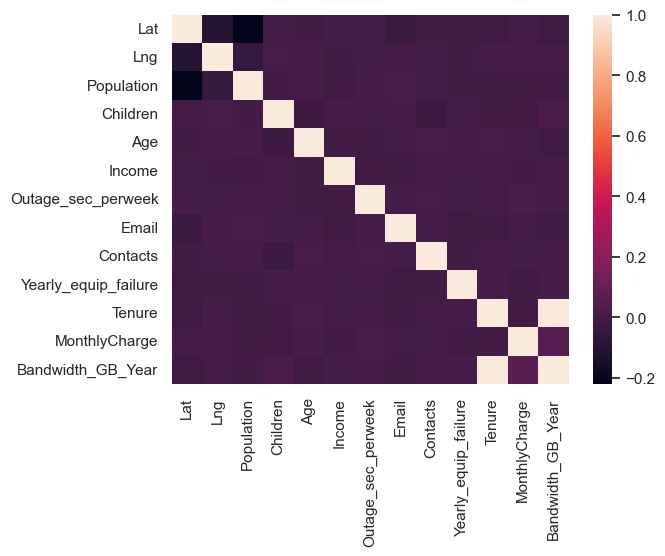

In [134]:
#check for variable correlations
corr = datmod.corr(numeric_only=True)
sns.heatmap(corr)

In [135]:
testvars = datmod.drop(['Bandwidth_GB_Year', 'Churn'], axis = 1).columns #list of variables to test
varskeep = [] #empty list for features
for x in testvars:
    #define groups
    group1 = datmod[datmod['Churn']==0]
    group2 = datmod[datmod['Churn']==1]

    #perform independent two sample t-test
    results = stats.ttest_ind(group1[x], group2[x])
    if results.pvalue < 0.01:
        print(x, results.pvalue)
        varskeep.append(x) #create a list of features to keep

Techie 2.4088023791818115e-11
Phone 0.008543973433772271
Multiple 5.642495343490838e-40
OnlineBackup 4.3392133940035626e-07
DeviceProtection 1.5789442802571253e-08
StreamingTV 2.414256535568512e-120
StreamingMovies 5.393071175178192e-192
Tenure 0.0
MonthlyCharge 0.0
Gender_Female 0.006887622543242016
Gender_Male 0.00501140233555871
Contract_Month-to-month 1.2367272028421725e-163
Contract_One year 2.35906753292585e-44
Contract_Two Year 3.019203802448564e-72
InternetService_DSL 7.391267040497883e-21
InternetService_Fiber Optic 4.873098307694272e-09
InternetService_None 0.0001599912049021959
PaymentMethod_Electronic Check 0.0027744606696484733


In [136]:
#add in the remaining corresponding dummy variables
varskeep.append('Gender_Nonbinary')
varskeep.append('PaymentMethod_Bank Transfer(automatic)')
varskeep.append('PaymentMethod_Credit Card (automatic)')
varskeep.append('PaymentMethod_Mailed Check') 
varskeep.append('Churn') #add churn to list
varskeep.sort()
datmod = datmod.loc[:, varskeep]
datmod.columns = varskeep
datmod.to_csv("~/Desktop/WGU/D208/churn_model_data_T2.csv")
datmod.head()

,Churn,Contract_Month-to-month,Contract_One year,Contract_Two Year,DeviceProtection,Gender_Female,Gender_Male,Gender_Nonbinary,InternetService_DSL,InternetService_Fiber Optic,InternetService_None,MonthlyCharge,Multiple,OnlineBackup,PaymentMethod_Bank Transfer(automatic),PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,Phone,StreamingMovies,StreamingTV,Techie,Tenure
0,0,0,1,0,0,0,1,0,0,1,0,172.455519,0,1,0,1,0,0,1,1,0,0,6.795513
1,1,1,0,0,0,1,0,0,0,1,0,242.632554,1,0,1,0,0,0,1,1,1,1,1.156681
2,0,0,0,1,0,1,0,0,1,0,0,159.947583,1,0,0,1,0,0,1,1,0,1,15.754144
3,0,0,0,1,0,0,1,0,1,0,0,119.956840,0,0,0,0,0,1,1,0,1,1,17.087227
4,1,1,0,0,0,0,1,0,0,1,0,149.948316,0,0,0,0,0,1,0,0,1,0,1.670972


<h2>Summary Statistics</h2>

In [137]:
datmod.describe()

,MonthlyCharge,Tenure
count,10000.000000,10000.000000
mean,172.624816,34.526188
std,42.943094,26.443063
min,79.978860,1.000259
25%,139.979239,7.917694
50%,167.484700,35.430507
75%,200.734725,61.479795
max,290.160419,71.999280


In [138]:
dat_cat = dat.loc[:, ['Techie', 
                      'Phone', 
                      'Multiple', 
                      'OnlineBackup', 
                      'DeviceProtection',
                      'StreamingTV', 
                      'StreamingMovies', 
                      'Gender', 
                      'Contract', 
                      'InternetService',
                      'PaymentMethod',
                      'Churn']]
dat_cat.columns = ['Techie', 
                      'Phone', 
                      'Multiple', 
                      'OnlineBackup', 
                      'DeviceProtection',
                      'StreamingTV', 
                      'StreamingMovies', 
                      'Gender', 
                      'Contract', 
                      'InternetService',
                      'PaymentMethod',
                      'Churn']

for col in dat_cat.columns:
    print(col)
    print(dat[col].value_counts())
    print()

Techie
No     8321
Yes    1679
Name: Techie, dtype: int64

Phone
Yes    9067
No      933
Name: Phone, dtype: int64

Multiple
No     5392
Yes    4608
Name: Multiple, dtype: int64

OnlineBackup
No     5494
Yes    4506
Name: OnlineBackup, dtype: int64

DeviceProtection
No     5614
Yes    4386
Name: DeviceProtection, dtype: int64

StreamingTV
No     5071
Yes    4929
Name: StreamingTV, dtype: int64

StreamingMovies
No     5110
Yes    4890
Name: StreamingMovies, dtype: int64

Gender
Female       5025
Male         4744
Nonbinary     231
Name: Gender, dtype: int64

Contract
Month-to-month    5456
Two Year          2442
One year          2102
Name: Contract, dtype: int64

InternetService
Fiber Optic    4408
DSL            3463
None           2129
Name: InternetService, dtype: int64

PaymentMethod
Electronic Check            3398
Mailed Check                2290
Bank Transfer(automatic)    2229
Credit Card (automatic)     2083
Name: PaymentMethod, dtype: int64

Churn
No     7350
Yes    2650
Name

<h2>Visualizations</h2>

In [139]:
#get data for graphs
plotvars = ['Techie', 'Phone', 'Multiple', 'OnlineBackup', 'DeviceProtection',
       'StreamingTV', 'StreamingMovies', 'Tenure', 'MonthlyCharge',
       'Gender', 'Contract', 'InternetService',
       'PaymentMethod', 'Churn']

datplots = dat[plotvars]

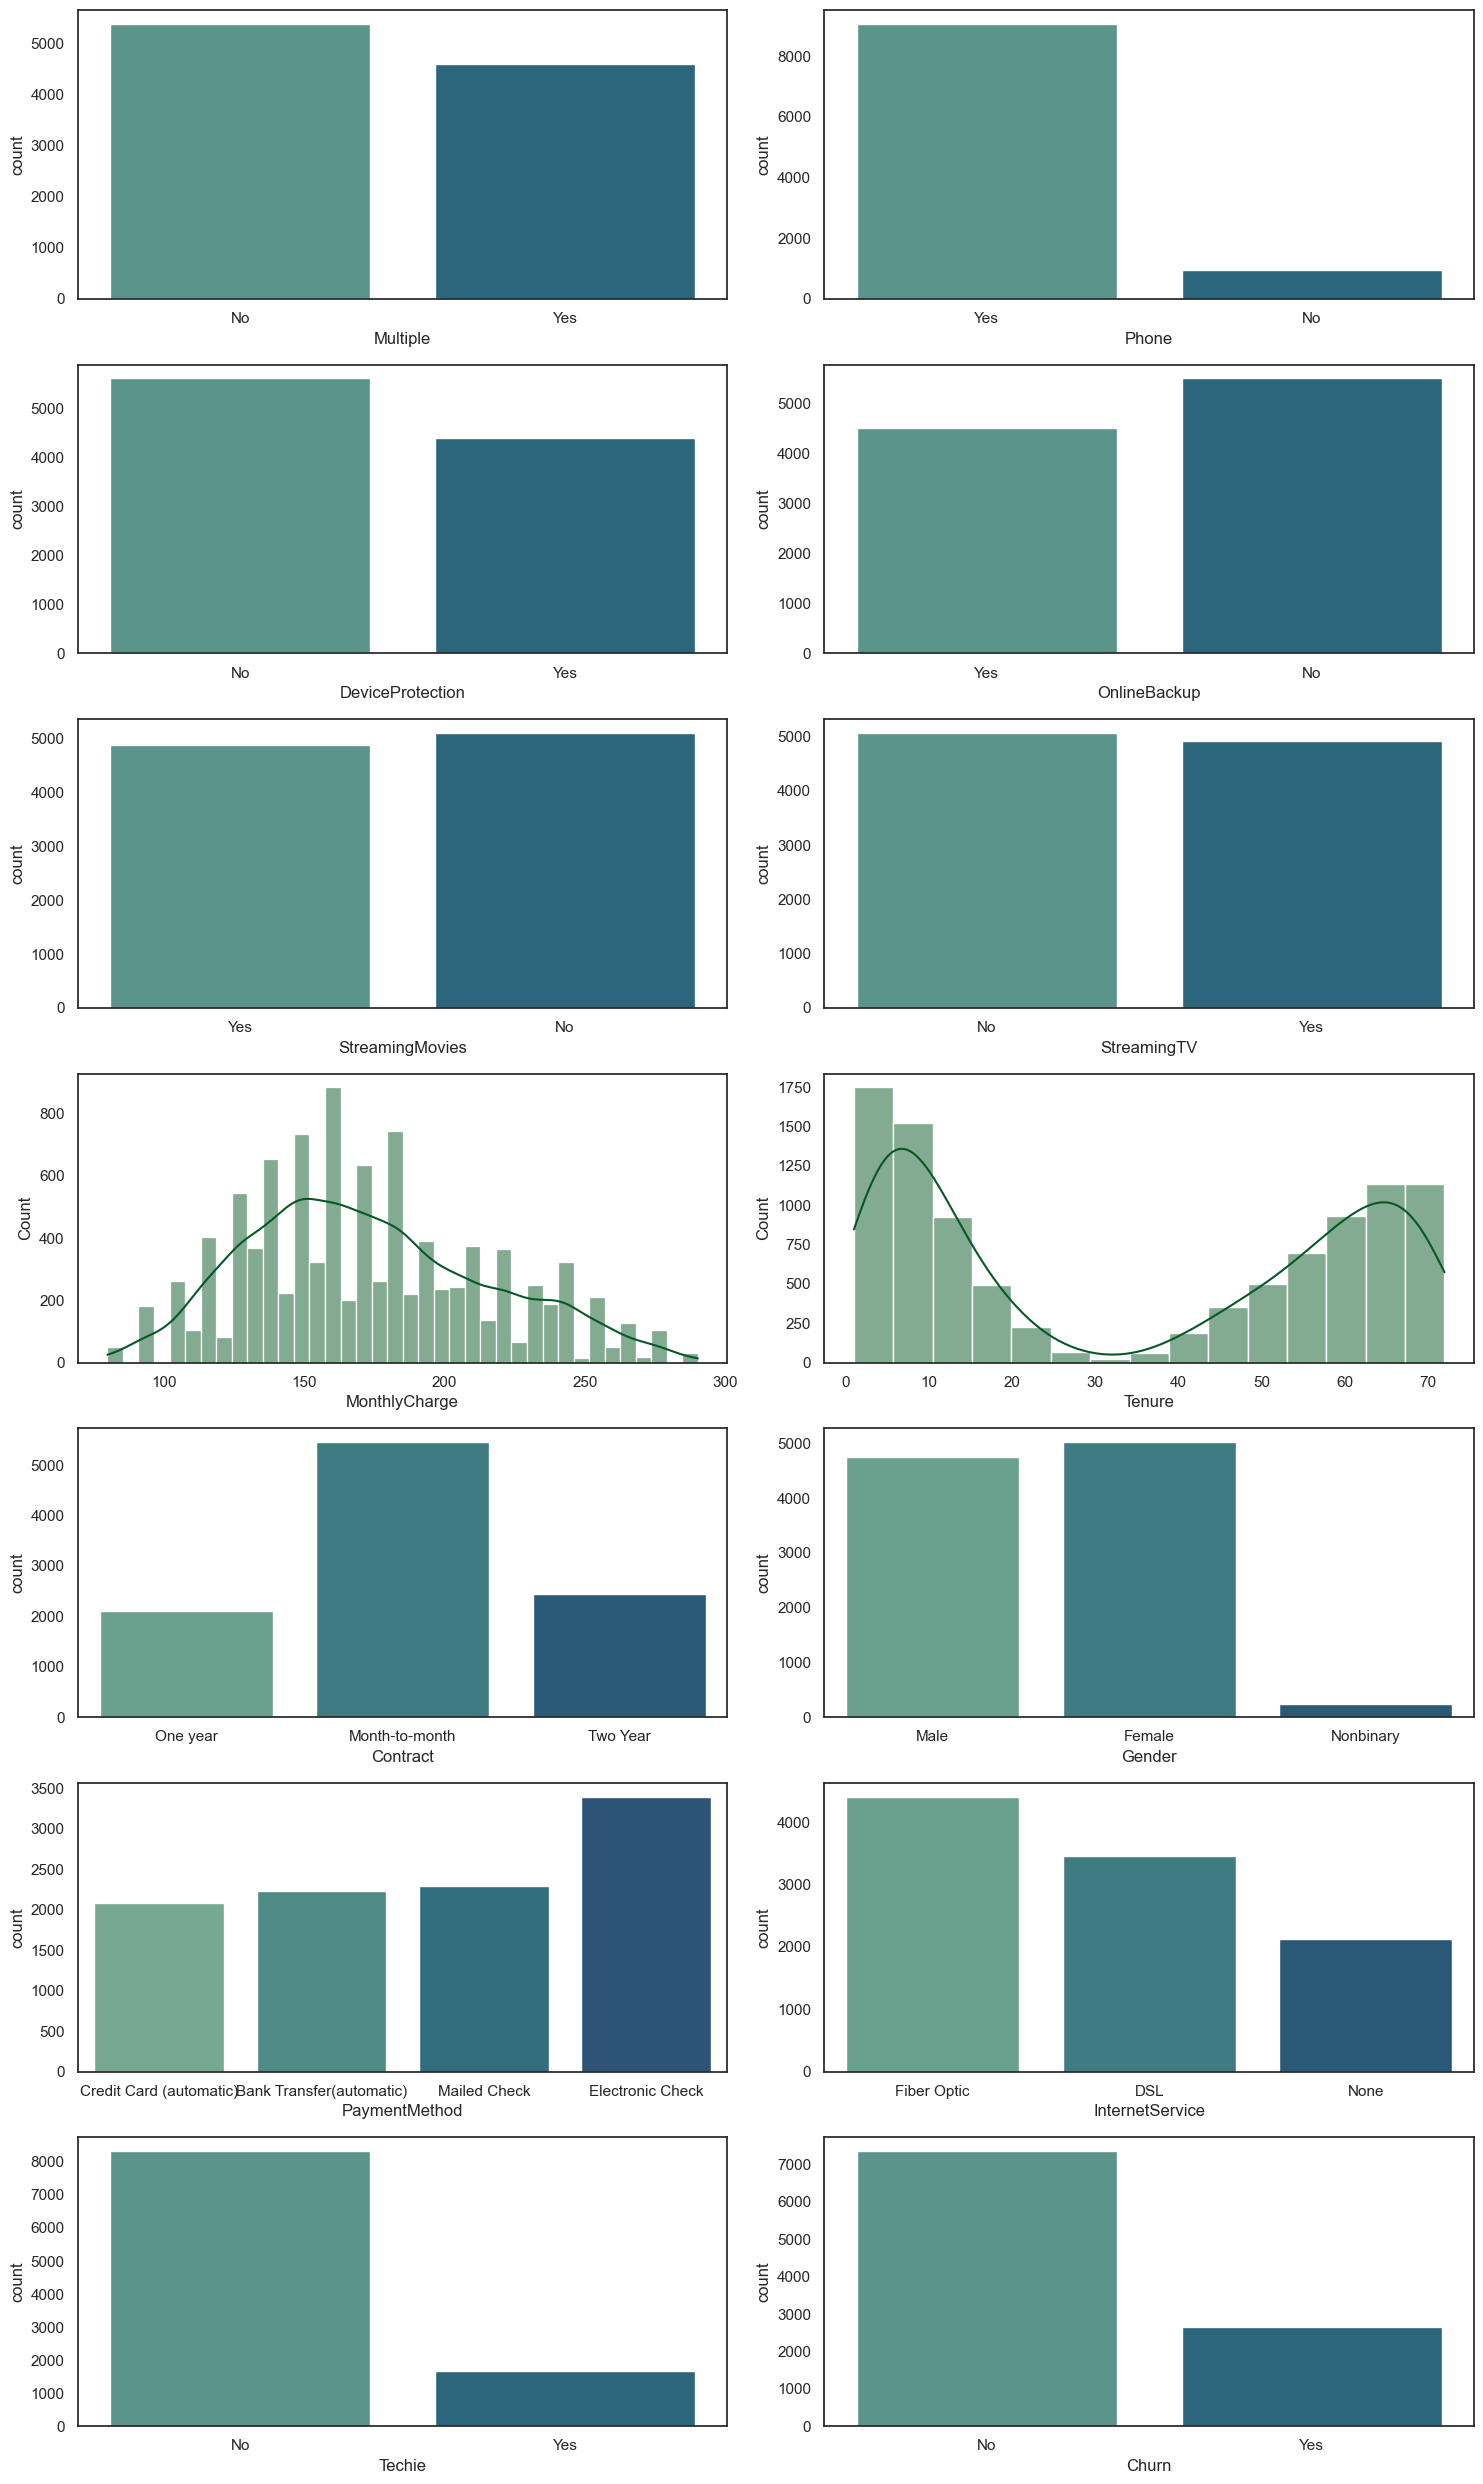

In [140]:
#univariate graphs
#set up figure window
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 25), sharey=False, sharex=False)#set up plots

for f in datplots.columns: #loop through all columns
    n = (list(datplots.columns).index(f)) #determine column number
    r = math.ceil(n/2) - 1
    c=1
    if (n%2)==0 : c=0
    
    if datplots[f].dtype == 'float64': #if datatype is numeric
        sns.histplot(data=datplots, x= f , kde=True, color = '#065824', ax=axes[r,c]) #plot histogram (univariate)
    else:
        sns.countplot(data=datplots, x=f, palette="crest", ax=axes[r,c]) #plot univariate barplot
        
plt.tight_layout()
plt.show()

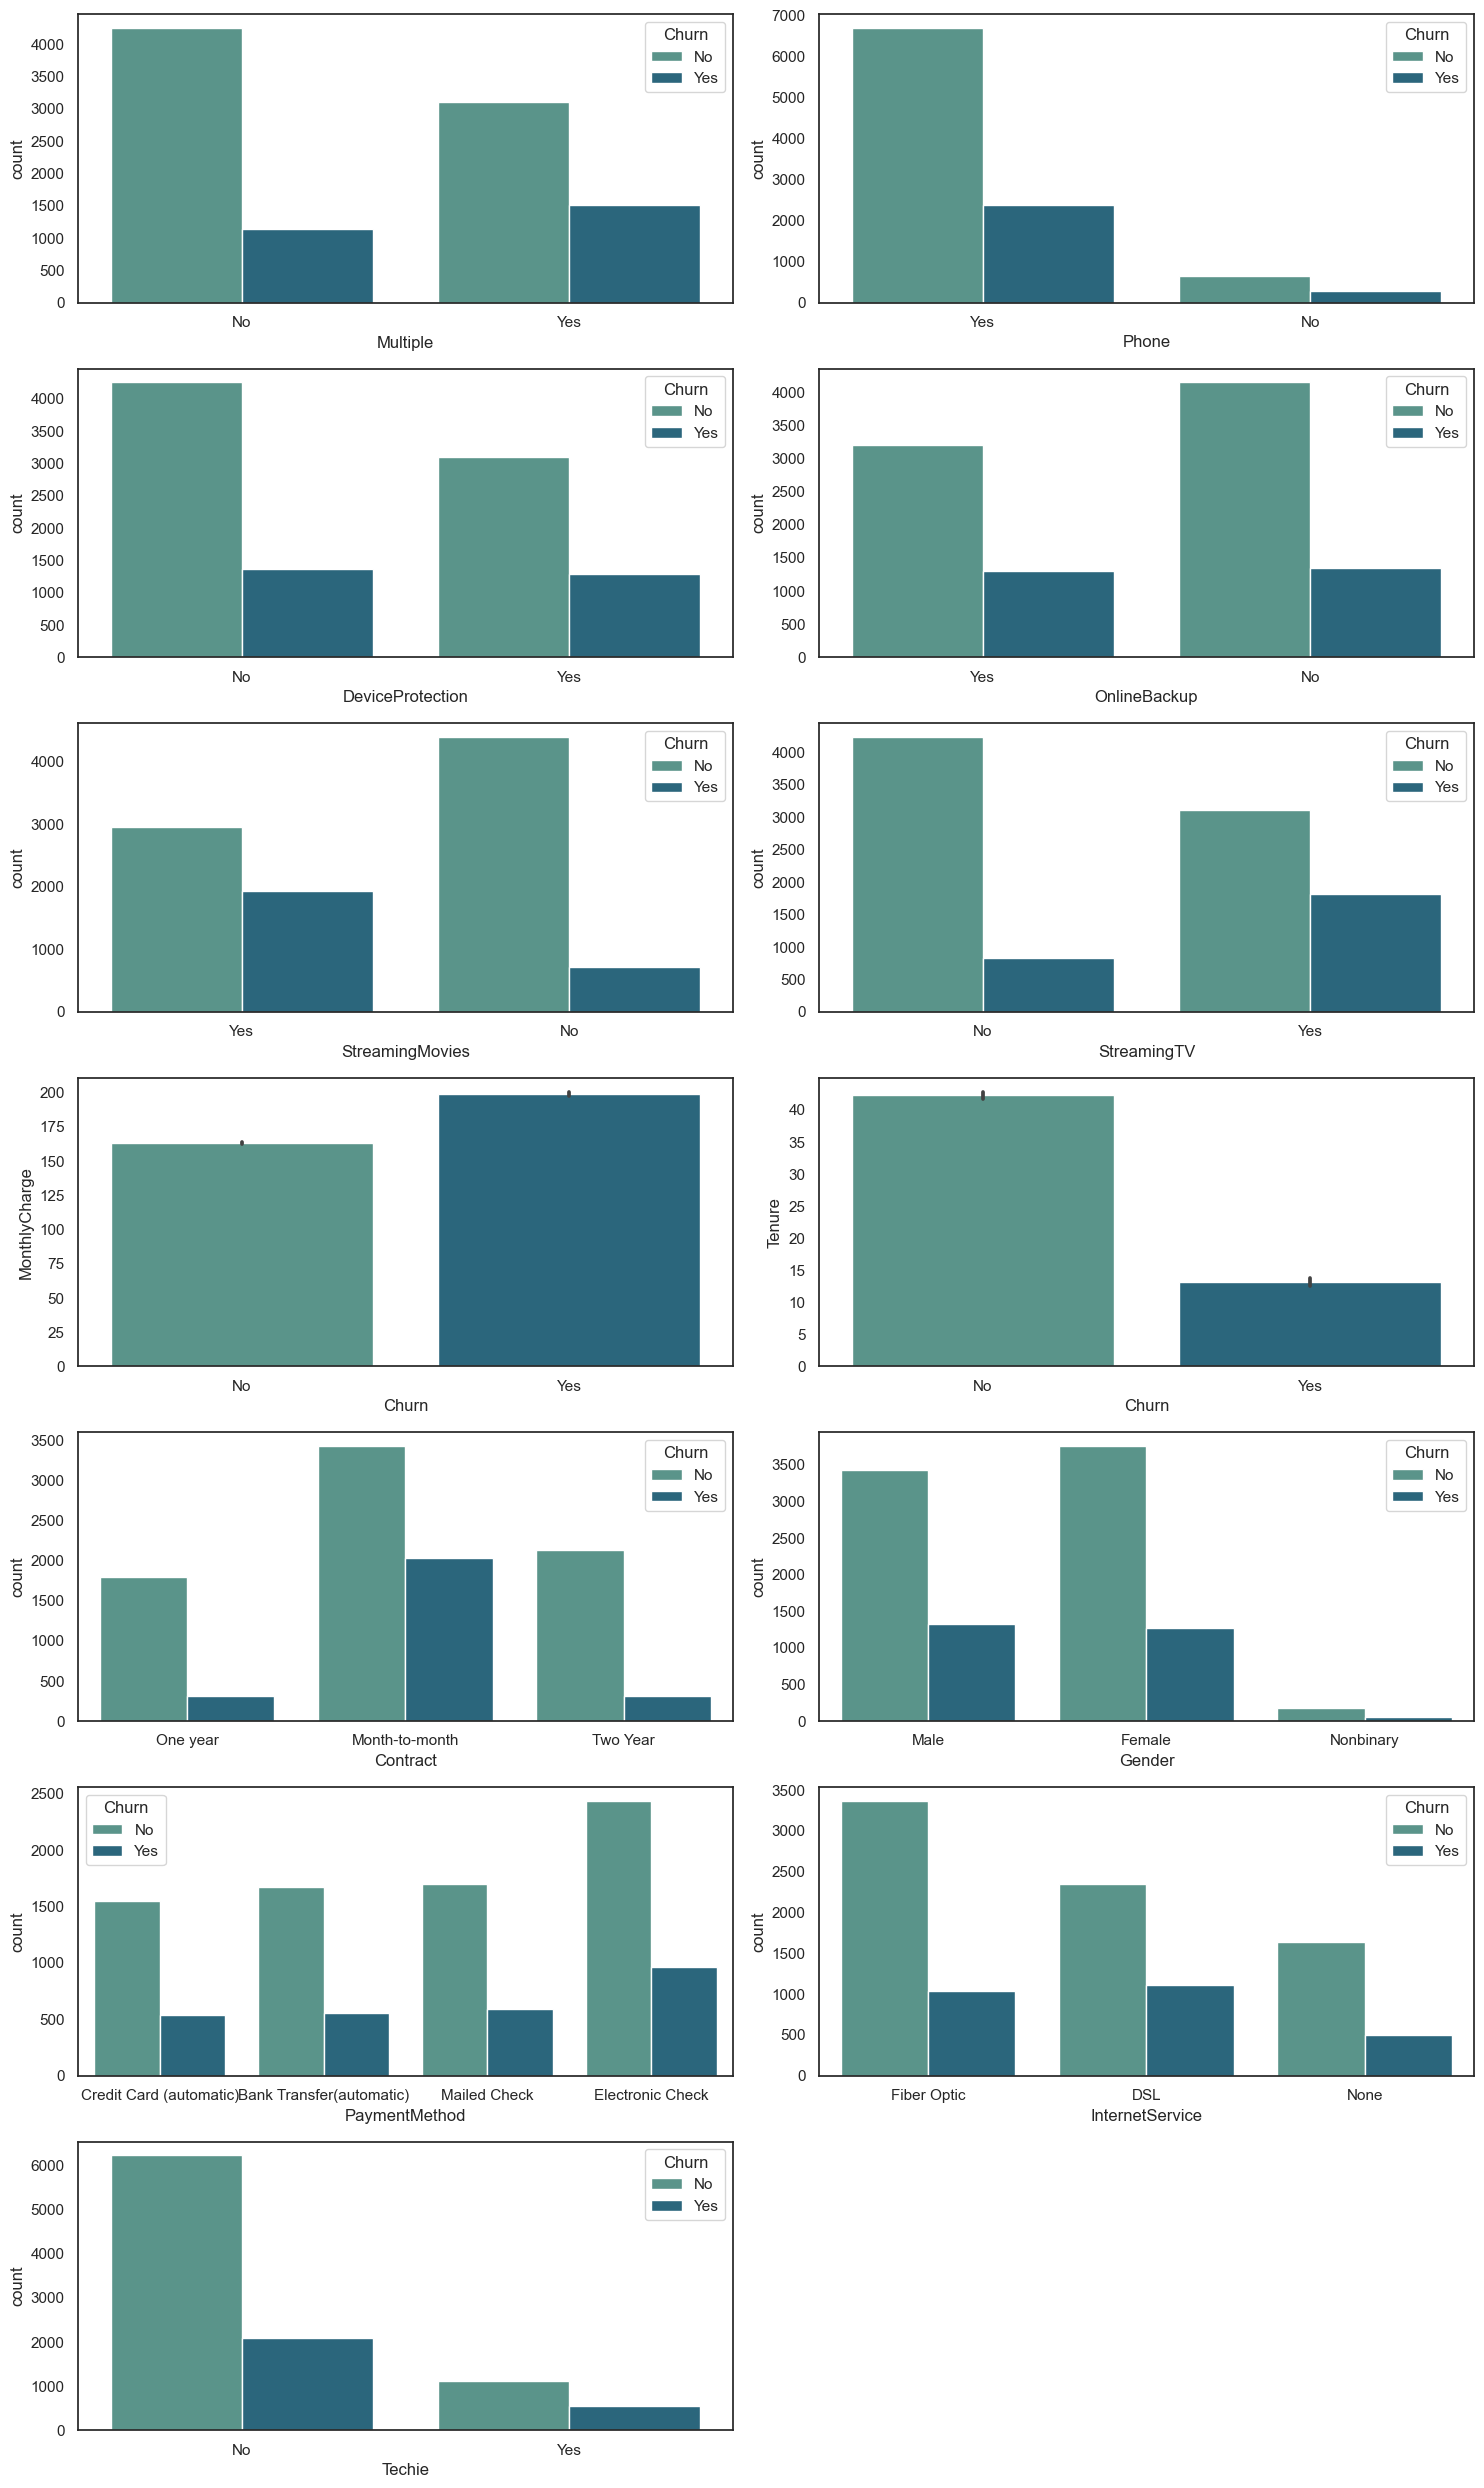

In [141]:
#bivariate plots

#set up figure window
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 25), sharey=False, sharex=False)#set up plots

for f in datplots.columns: #loop through all columns
    n = (list(datplots.columns).index(f)) #determine column number
    r = math.ceil(n/2) - 1
    c=1
    if (n%2)==0 : c=0
    
    if datplots[f].dtype == 'float64': #if datatype is numeric
        sns.barplot(data=datplots, y= f, x="Churn", palette="crest", ax=axes[r,c]) #plot barplot vs. churn (bivariate)
    else:
        sns.countplot(data=datplots, x=f,  hue="Churn", palette="crest", ax=axes[r,c])#plot bivariate countplot vs. churn

        
plt.delaxes(axes[6,1])

plt.tight_layout()
plt.show()

<h2>Initial Model</h2>

In [162]:
#need to balance churn data - use Synthetic Minority Oversampling Technique (SMOTE)
X = np.array(datmod.drop('Churn',axis= 1)) #predictor (independent) variables
y = np.array(datmod['Churn']) #dependent variable

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#columns = X_train.columns
Xmod, ymod = os.fit_resample(X_train, y_train)
Xmod = pd.DataFrame(data=Xmod,columns=datmod.drop('Churn',axis= 1).columns )
ymod= pd.DataFrame(data=ymod,columns=['Churn'])

#round the filled in data
cols = ['Techie', 'Phone', 'Multiple', 'OnlineBackup', 'DeviceProtection',
       'StreamingTV', 'StreamingMovies',
       'Gender_Female', 'Gender_Male', 'Gender_Nonbinary', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two Year', 'InternetService_DSL',
       'InternetService_Fiber Optic', 'InternetService_None',
       'PaymentMethod_Electronic Check',
       'PaymentMethod_Bank Transfer(automatic)',
       'PaymentMethod_Credit Card (automatic)', 'PaymentMethod_Mailed Check']

for f in cols: Xmod[f] = Xmod[f].round()
ymod = ymod.round()

datbal = pd.concat([ymod, Xmod], axis=1)
datbal.to_csv("~/Desktop/WGU/D208/churn_model_data_T2_Balanced.csv")
# we can Check the numbers of our data
print("Number of no churn:  ",len(ymod[ymod['Churn']==0]))
print("Number of churn:  ",len(ymod[ymod['Churn']==1]))
datbal.info()

Number of no churn:   5149
Number of churn:   5149
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10298 entries, 0 to 10297
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Churn                                   10298 non-null  int64  
 1   Contract_Month-to-month                 10298 non-null  float64
 2   Contract_One year                       10298 non-null  float64
 3   Contract_Two Year                       10298 non-null  float64
 4   DeviceProtection                        10298 non-null  float64
 5   Gender_Female                           10298 non-null  float64
 6   Gender_Male                             10298 non-null  float64
 7   Gender_Nonbinary                        10298 non-null  float64
 8   InternetService_DSL                     10298 non-null  float64
 9   InternetService_Fiber Optic             10298 non-null  float64
 10  Interne

In [163]:
#scale data
scaler = preprocessing.StandardScaler()
ymod = pd.DataFrame(scaler.fit_transform(ymod), columns = ymod.columns)
Xmod = pd.DataFrame(scaler.fit_transform(Xmod), columns = Xmod.columns)
scaleX_mod = scaler.scale_ #create scaler list for unscaling the coefficients


In [169]:
scaleX_mod

array([ 0.48499385,  0.38267256,  0.40017469,  0.49819598,  0.49999788,
        0.49944288,  0.1471395 ,  0.48253494,  0.49445076,  0.40390796,
       44.4447995 ,  0.49996605,  0.49857841,  0.41202476,  0.40155015,
        0.47671538,  0.42210061,  0.2896533 ,  0.4947102 ,  0.49660512,
        0.38177172, 25.50673551])

In [242]:
def log_reg(X, y, scaleX):  
    
    # creating train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    model = LogisticRegression() # creating model
    model.fit(X_train,y_train.values.ravel()) # fitting the model
    predict_test = model.predict(X_test) #make predictions on test data
    predict_train = model.predict(X_train) #make predictions from training data
    
    print('Accuracy:  ' , metrics.accuracy_score(y_test, predict_test))
    print('Avg Precision:  ', metrics.average_precision_score(y_test, predict_test))
    print('F1 score:  ', metrics.f1_score(y_test, predict_test))
    
    #print regression coefficients
    coef_sc = pd.DataFrame(model.coef_.T)
    coef_unsc = pd.DataFrame(np.true_divide(model.coef_,  scaleX).T)
    odds = pd.DataFrame(np.exp(coef_unsc))
    coefficients=pd.concat([coef_sc, coef_unsc], axis=1)
    coefficients.index = X.columns
    coefficients.columns=['Scaled Coefs', 'Unscaled Coefs']
    print(coefficients)
    
    odds.index = X.columns
    odds.columns = ['Odds and Odds Ratios']
    print("")
    print(odds)
    
    cm = metrics.confusion_matrix(y_test, predict_test)
    print("")
    print("Confusion Matrix:")
    print(cm)
    
    
    #check linearity assumption with log-odds
    # Getting log odds values
    probs =  model.predict_proba(X_test)
    log_odds = np.log(probs[:,0] / probs[:,1])
    Xdf = pd.DataFrame(X_test, columns = Xmod.columns)
    # Visualize predictor variable vs logit values for Age
    print('Correlation:', np.corrcoef(Xdf['Tenure'], log_odds)[0,1])
    plt.scatter(x=Xdf['Tenure'], y=log_odds)
    plt.xlabel("Tenure")
    plt.ylabel("Log-odds")
    plt.show()
    
    print('Correlation:', np.corrcoef(Xdf['MonthlyCharge'], log_odds)[0,1])
    plt.scatter(x=Xdf['MonthlyCharge'], y=log_odds)
    plt.xlabel("MonthlyCharge")
    plt.ylabel("Log-odds")
    plt.show()
    


Accuracy:   0.8948220064724919
Avg Precision:   0.8492656211102813
F1 score:   0.8961992973490898
                                        Scaled Coefs  Unscaled Coefs
Contract_Month-to-month                     0.981838        2.024434
Contract_One year                          -0.568363       -1.485248
Contract_Two Year                          -0.646438       -1.615390
DeviceProtection                            0.140346        0.281709
Gender_Female                              -0.030052       -0.060105
Gender_Male                                 0.033247        0.066569
Gender_Nonbinary                           -0.010731       -0.072933
InternetService_DSL                         0.495951        1.027803
InternetService_Fiber Optic                -0.457613       -0.925498
InternetService_None                       -0.032300       -0.079970
MonthlyCharge                               1.484113        0.033392
Multiple                                    0.304227        0.608495
Onlin

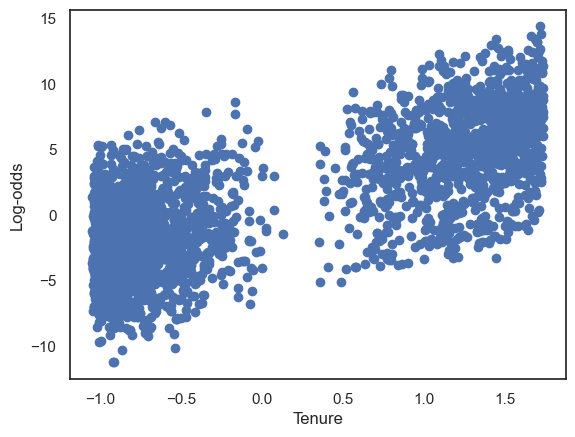

Correlation: -0.5703557025348658


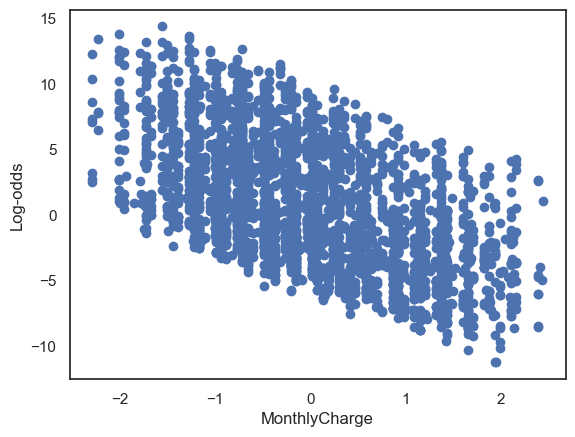

In [243]:
log_reg(Xmod, ymod, scaleX_mod) #run model

<h2>Model Reduction</h2>

In [223]:
#Use RFE to remove not significant features from the initial model
logreg = LogisticRegression()
selector = RFE(logreg)
selector = selector.fit(Xmod, ymod.values.ravel())

#New features dataframe containing only selected features through RFE
X_RFE = Xmod[Xmod.columns[selector.support_]]
X_RFE.columns

Index(['Contract_Month-to-month', 'Contract_One year', 'Contract_Two Year',
       'InternetService_DSL', 'InternetService_Fiber Optic', 'MonthlyCharge',
       'Multiple', 'StreamingMovies', 'StreamingTV', 'Techie', 'Tenure'],
      dtype='object')

<h2>Reduced Model</h2>

Accuracy:   0.8957928802588997
Avg Precision:   0.8502106920352503
F1 score:   0.8972559029993618
                             Scaled Coefs  Unscaled Coefs
Contract_Month-to-month          0.960774        1.981003
Contract_One year               -0.557332       -1.456420
Contract_Two Year               -0.631459       -1.577959
InternetService_DSL              0.483172        1.001320
InternetService_Fiber Optic     -0.513884       -1.039302
MonthlyCharge                    1.734365        0.039023
Multiple                         0.200896        0.401820
StreamingMovies                  0.742929        1.501745
StreamingTV                      0.708933        1.427558
Techie                           0.430438        1.127475
Tenure                          -3.030526       -0.118813

                             Odds and Odds Ratios
Contract_Month-to-month                  7.250010
Contract_One year                        0.233069
Contract_Two Year                        0.206396
Inter

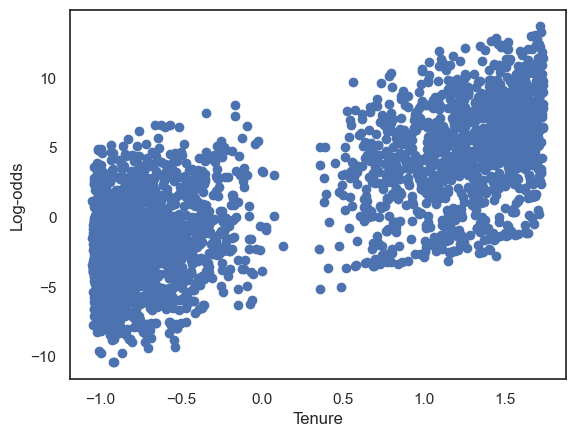

Correlation: -0.5725128914340245


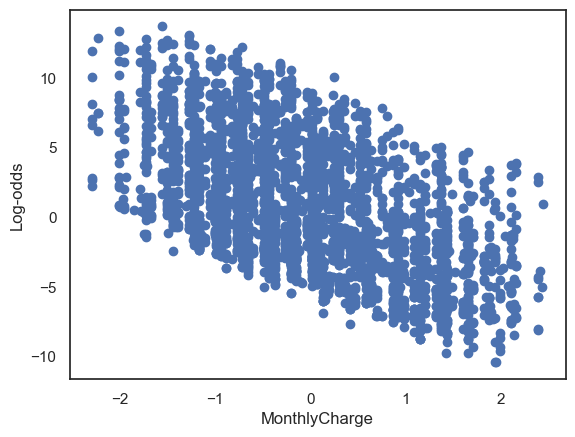

In [244]:
scaleX_RFE = scaleX_mod[selector.support_]
log_reg(X_RFE, ymod, scaleX_RFE) #run model